In [1]:
import torch
import data_prepro

c:\Users\ParkJeongSu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device='cpu'

In [3]:
from torch.nn.utils import weight_norm
import torch.nn as nn

In [4]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

In [5]:
from torch.nn.utils import weight_norm

m = weight_norm(nn.Linear(20, 40), name='weight')
m # Linear(in_features=20, out_features=40, bias=True)
m.weight_g.size() # torch.Size([40, 1])
m.weight_v.size() # torch.Size([40, 20])

torch.Size([40, 20])

In [6]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

In [7]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                             
                             
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [8]:
import torch.nn.functional as F
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

In [9]:
num_epochs = 300 #1000 epochs
learning_rate = 0.00005 #0.001 lr

kernel_size = 5
stride = 1
dilation = 1
padding=2
dropout=0.2
input_size = 60 #number of features
hidden_size = 256 #number of features in hidden state
num_channels = [512,512,256] #number of stacked lstm layers

output_size = 4 #number of output classes 

In [10]:
device = torch.device('cpu')
model = TCN(input_size, output_size, num_channels, kernel_size, dropout)
model.load_state_dict(torch.load('tcn_rescale_500epochs.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
train,test = data_prepro.loadData('datasets/data_tr_city.csv','datasets/data_ts_city.csv',trainYearRange1=2019,trainYearRange2=2020)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35063 entries, 0 to 35062
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             35063 non-null  object 
 1   구미 혁신도시배수지 유출유량 적산차  35055 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             8424 non-null   object 
 1   구미 혁신도시배수지 유출유량 적산차  8424 non-null   float64
dtypes: float64(1), object(1)
memory usage: 131.8+ KB
None


In [12]:
train = data_prepro.outlierDataToNan(train,low=True,high=False,thres=10.0)
# train = data_prepro.fillZero(train)
train = data_prepro.fillnaBehind(train)
train = data_prepro.fillprevValue(train)

Int64Index([17558, 21595, 25626], dtype='int64')
index                  0
datetime               0
구미 혁신도시배수지 유출유량 적산차    2
year                   0
month                  0
dtype: int64


In [13]:
train,reScale = data_prepro.reScale(train)

In [14]:
test,_ = data_prepro.reScale(test,reScale)

In [ ]:
test = reScale.inverse_transform(test)

In [15]:
X,Y = data_prepro.XDataToXAndYSeq(train,step = 60,output=4)

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319


In [16]:
X = X.reshape(-1,).tolist()

In [17]:
Y_pred = []

In [19]:
for i in range(365*24): # 2021년 전체 예측
    pred = model(torch.Tensor(X[-input_size:]).reshape(1,input_size,1)).tolist()[0][0]
    X.append(pred)
    Y_pred.append(pred)

In [20]:
Y_pred

[0.27758899331092834,
 0.27369001507759094,
 0.2560436427593231,
 0.21925820410251617,
 0.18724800646305084,
 0.13601621985435486,
 0.09814979135990143,
 0.06549415737390518,
 0.038985803723335266,
 0.021679656580090523,
 0.033171553164720535,
 0.0317268893122673,
 0.0928640216588974,
 0.21690703928470612,
 0.34563666582107544,
 0.26950356364250183,
 0.27482134103775024,
 0.2649436891078949,
 0.2566193640232086,
 0.2363002449274063,
 0.1771261990070343,
 0.18863897025585175,
 0.21153409779071808,
 0.27743884921073914,
 0.3182557225227356,
 0.31712254881858826,
 0.25112953782081604,
 0.21394293010234833,
 0.17231138050556183,
 0.12537570297718048,
 0.07354230433702469,
 0.040680158883333206,
 0.019421184435486794,
 0.017919544130563736,
 0.013211552053689957,
 0.051281288266181946,
 0.16122743487358093,
 0.2613999843597412,
 0.3300781846046448,
 0.26828324794769287,
 0.2468915730714798,
 0.24514737725257874,
 0.2300686538219452,
 0.20330451428890228,
 0.2184610366821289,
 0.180211558938

In [22]:
import numpy as np

In [23]:
result = np.array(Y_pred).reshape(-1,1)

In [25]:
result1 = reScale.inverse_transform(result)

In [27]:
import matplotlib.pyplot as plt

In [28]:
train,test = data_prepro.loadData('datasets/data_tr_city.csv','datasets/data_ts_city.csv',trainYearRange1=2019,trainYearRange2=2020)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35063 entries, 0 to 35062
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             35063 non-null  object 
 1   구미 혁신도시배수지 유출유량 적산차  35055 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             8424 non-null   object 
 1   구미 혁신도시배수지 유출유량 적산차  8424 non-null   float64
dtypes: float64(1), object(1)
memory usage: 131.8+ KB
None


In [29]:
testDataY = test['구미 혁신도시배수지 유출유량 적산차'].to_numpy()

In [32]:
testDataY

array([106., 184., 277., ..., 396., 350., 197.])

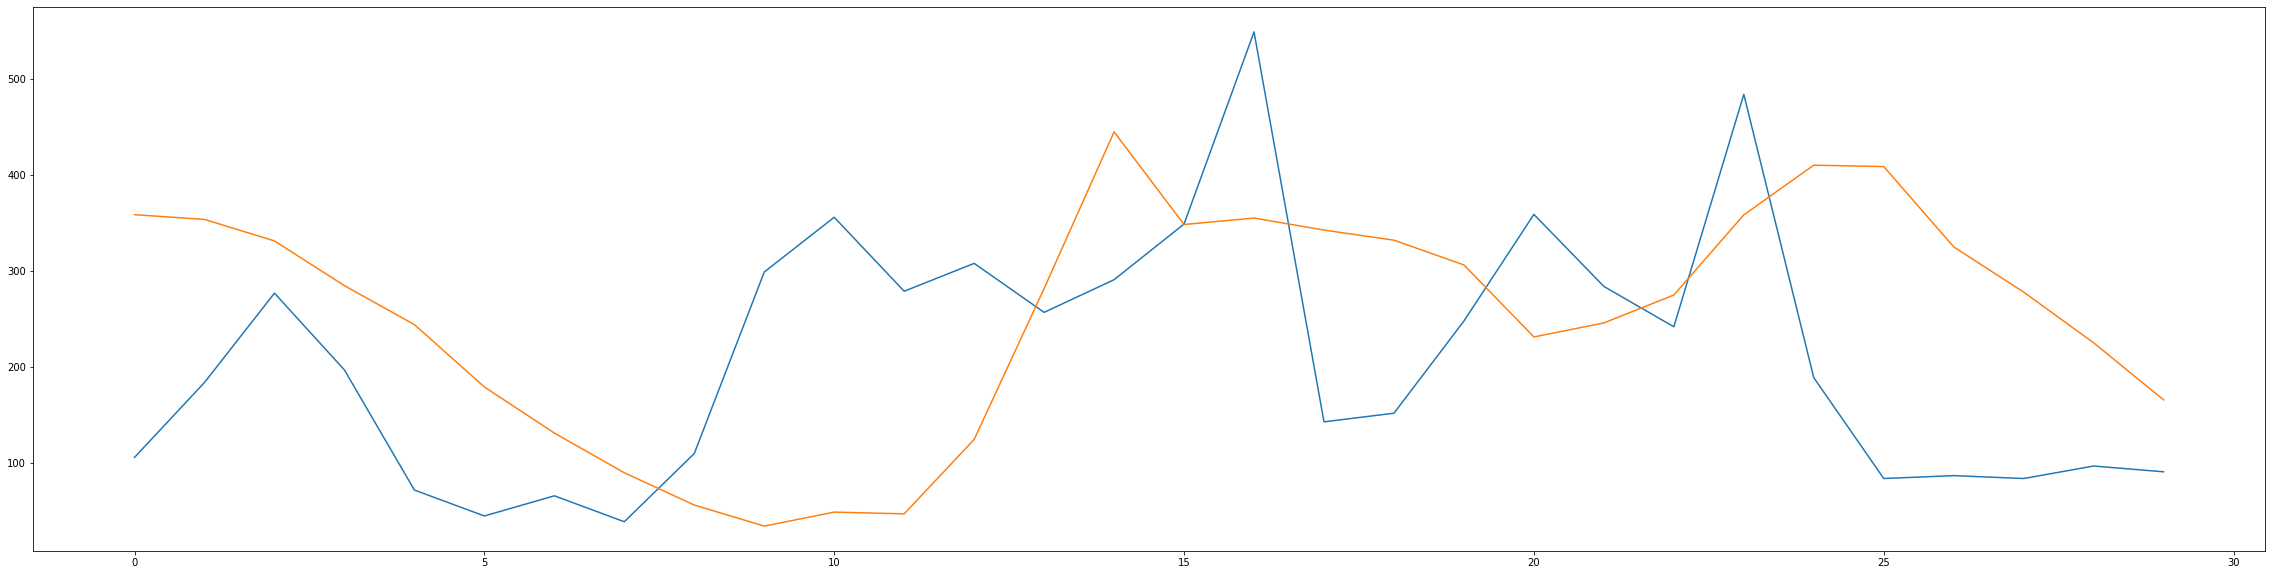

In [40]:
plt.figure(figsize=(40,10))
plt.plot(range(len(testDataY[:30])),testDataY[:30])
plt.plot(range(len(result1[:30])),result1[:30])

In [ ]:
plt.plot(range(len(testDataY[300:])),testDataY[300:])
plt.plot(range(len(result1[:len(testDataY)])),result1[:len(testDataY)].reshape(-1,))